In [1]:
import numpy as np
import pandas as pd

parent_1_shifts = {
    'shift_1': {
        'start_hour': 9,
        'end_hour': 17
    },
    'shift_2': {
        'start_hour': 10,
        'end_hour': 16
    }
}

parent_2_shift_probabilities = {
    'shift_1': {
        'start_hour': 6,
        'end_hour': 14,
        'probability': 0.27
    },
    'shift_2': {
        'start_hour': 6,
        'end_hour': 24,
        'probability': 0.05
    },
    'shift_3': {
        'start_hour': 6,
        'end_hour': 18,
        'probability': 0.02
    },
    'shift_4': {
        'start_hour': 8,
        'end_hour': 12,
        'probability': 0.02
    },
    'shift_5': {
        'start_hour': 8,
        'end_hour': 16,
        'probability': 0.07
    },
    'shift_6': {
        'start_hour': 8,
        'end_hour': 15,
        'probability': 0.1
    },
    'shift_7': {
        'start_hour': 10,
        'end_hour': 18,
        'probability': 0.01
    },
    'shift_8': {
        'start_hour': 11.5,
        'end_hour': 19.5,
        'probability': 0.16
    },
    'shift_9': {
        'start_hour': 12,
        'end_hour': 22,
        'probability': 0.02
    },
    'shift_10': {
        'start_hour': 14,
        'end_hour': 22,
        'probability': 0.16
    },
    'shift_11': {
        'start_hour': 15,
        'end_hour': 22,
        'probability': 0.06
    },
    'shift_12': {
        'start_hour': 16,
        'end_hour': 24,
        'probability': 0.05
    },
    'shift_13': {
        'start_hour': 22,
        'end_hour': 24,
        'probability': 0.01
    },
}

parent_1_work_prob = 1
parent_2_work_prob = 0.47



In [2]:
def simulate_parent_2_schedule(num_days=5):
    parent_2_daily_schedule = []

    for day in range(num_days):
        if np.random.rand() < parent_2_work_prob:
            shift = np.random.choice(
                list(parent_2_shift_probabilities.keys()), 
                p=[parent_2_shift_probabilities[shift]['probability'] for shift in parent_2_shift_probabilities]
            )
            start_hour = parent_2_shift_probabilities[shift]['start_hour']
            end_hour = parent_2_shift_probabilities[shift]['end_hour']
            
            # Check if it's Wednesday (Day 2)
            if day == 2:  # Assuming day 0 is Monday, day 2 is Wednesday
                meeting_start = 13
                meeting_end = 16
                # If the shift doesn't cover the meeting, adjust the schedule
                if end_hour <= meeting_start:  # Shift ends before the meeting starts
                    end_hour = meeting_end  # Extend shift to cover the meeting
                elif start_hour >= meeting_end:  # Shift starts after the meeting ends
                    parent_2_daily_schedule.append({'start_hour': meeting_start, 'end_hour': end_hour})
                    continue  # Skip the rest since we've already added both shifts
                else:  # Shift overlaps with the meeting
                    if start_hour > meeting_start:
                        start_hour = meeting_start  # Ensure shift starts at or before meeting
                    if end_hour < meeting_end:
                        end_hour = meeting_end  # Ensure shift ends at or after meeting
                
            parent_2_daily_schedule.append({'start_hour': start_hour, 'end_hour': end_hour})
        else:
            # No work day
            if day == 2:  # If it's Wednesday and they have a meeting
                parent_2_daily_schedule.append({'start_hour': 14, 'end_hour': 16})
            else:
                parent_2_daily_schedule.append({'start_hour': None, 'end_hour': None})

    return parent_2_daily_schedule

parent_1_schedules = [
    parent_1_shifts['shift_2'],
    parent_1_shifts['shift_1'],
    parent_1_shifts['shift_1'],
    parent_1_shifts['shift_1'],
    parent_1_shifts['shift_2']
]

In [3]:
parent_2_schedules_52weeks = [simulate_parent_2_schedule() for _ in range(52)]
parent_1_schedules_52weeks = [parent_1_schedules for _ in range(52)]

In [4]:
# visualize the schedule coverage

def visualize_schedule_coverage(parent_1_schedules, parent_2_schedules):
    hours_covered = [0 for _ in range(24)]
    child_care_needed = [0 for _ in range(24)]
    for schedule_1, schedule_2 in zip(parent_1_schedules, parent_2_schedules):
        for day in range(5):
            parent_1_day = schedule_1[day]
            if parent_1_day['start_hour'] is not None:
                for hour in range(int(round(parent_1_day['start_hour'], 0)), int(round(parent_1_day['end_hour'], 0))):
                    hours_covered[hour] += 1
            parent_2_day = schedule_2[day]
            if parent_2_day['start_hour'] is not None:
                for hour in range(int(round(parent_2_day['start_hour'], 0)), int(round(parent_2_day['end_hour'], 0))):
                    hours_covered[hour] += 1
            start_hour = None
            end_hour = None
            if parent_2_day['start_hour'] is None:
                continue
            if parent_1_day['start_hour'] is None:
                continue
            if parent_1_day['start_hour'] < parent_2_day['start_hour'] and parent_1_day['end_hour'] > parent_2_day['start_hour']:
                start_hour = parent_2_day['start_hour']-1
            else:
                start_hour = parent_1_day['start_hour']-1
            if parent_1_day['end_hour'] > parent_2_day['end_hour'] and parent_1_day['start_hour'] < parent_2_day['end_hour']:
                end_hour = parent_2_day['end_hour']+1
            else:
                end_hour = parent_1_day['end_hour']+1
            for hour in range(int(round(start_hour, 0)), int(round(end_hour, 0))):
                child_care_needed[hour] += 1

    return hours_covered, child_care_needed

hours_covered, hours_needed = visualize_schedule_coverage(parent_1_schedules_52weeks, parent_2_schedules_52weeks)




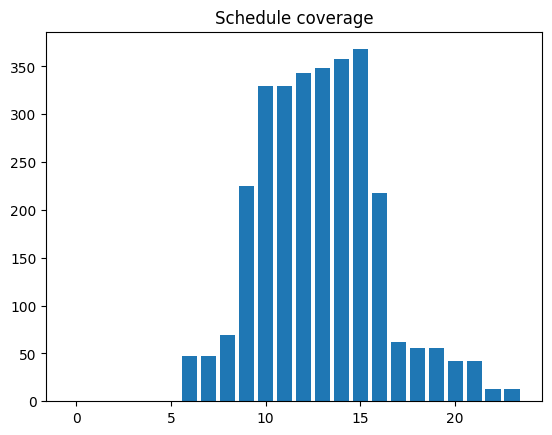

In [5]:
# visualize the schedule coverage
import matplotlib.pyplot as plt

plt.bar(range(24), hours_covered)
plt.title('Schedule coverage')

plt.show()

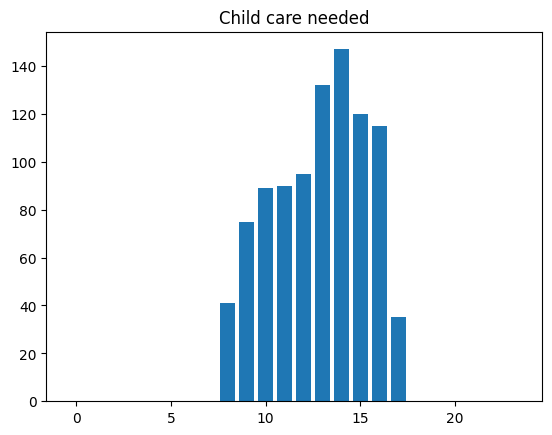

In [6]:
# visualize the schedule needed

plt.bar(range(24), hours_needed)
plt.title('Child care needed')

plt.show()

In [7]:
def calculate_childcare_hours_wk(parent_1_week, parent_2_week):
    childcare_week = []
    for parent_1_day, parent_2_day in zip(parent_1_week, parent_2_week):
        childcare_hours = [0 for _ in range(24)]
        start_hour = None
        end_hour = None
        
        # If either parent is not working that day, skip childcare needs for that day
        if parent_1_day['start_hour'] is None or parent_2_day['start_hour'] is None:
            childcare_week.append(childcare_hours)
            continue
        
        # Determine the start hour based on overlapping schedules
        if parent_1_day['start_hour'] < parent_2_day['start_hour'] and parent_1_day['end_hour'] > parent_2_day['start_hour']:
            start_hour = parent_2_day['start_hour'] - 1
        else:
            start_hour = parent_1_day['start_hour'] - 1

        # Determine the end hour based on overlapping schedules
        if parent_1_day['end_hour'] > parent_2_day['end_hour'] and parent_1_day['start_hour'] < parent_2_day['end_hour']:
            end_hour = parent_2_day['end_hour'] + 1
        else:
            end_hour = parent_1_day['end_hour'] + 1
        
        # Mark the hours that need childcare coverage
        for hour in range(int(round(start_hour, 0)), int(round(end_hour, 0)) + 1):
            childcare_hours[hour] = 1
        
        childcare_week.append(childcare_hours)
    
    return childcare_week

def calculate_childcare_hours_wk(parent_1_week, parent_2_week):
    childcare_week = []
    
    for parent_1_day, parent_2_day in zip(parent_1_week, parent_2_week):
        childcare_hours = [0] * 24  # Initialize the day with no childcare needed
        
        # If one or both parents are not working that day, no childcare is needed
        if parent_1_day['start_hour'] is None or parent_2_day['start_hour'] is None:
            childcare_week.append(childcare_hours)
            continue
        
        # Calculate potential start and end hours for childcare coverage
        start_hour = max(parent_1_day['start_hour'], parent_2_day['start_hour'])-1
        end_hour = min(parent_1_day['end_hour'], parent_2_day['end_hour'])+1
        
        # Handle cases where there's no overlap but still need coverage:
        if parent_1_day['end_hour'] <= parent_2_day['start_hour']:
            # Parent 1 finishes before Parent 2 starts
            start_hour = parent_1_day['end_hour']+1
            end_hour = parent_2_day['start_hour']-1
        elif parent_2_day['end_hour'] <= parent_1_day['start_hour']:
            # Parent 2 finishes before Parent 1 starts
            start_hour = parent_2_day['end_hour']+1
            end_hour = parent_1_day['start_hour']-1
        else:
            # There is overlap or direct transition between parents
            start_hour = max(parent_1_day['start_hour'], parent_2_day['start_hour'])-1
            end_hour = min(parent_1_day['end_hour'], parent_2_day['end_hour'])+1

        # Mark the hours that need childcare coverage
        if start_hour < end_hour:
            for hour in range(int(round(start_hour)), int(round(end_hour, 0)) + 1):
                childcare_hours[hour] = 1
        
        childcare_week.append(childcare_hours)
    
    return childcare_week

In [8]:
for week in range(52):
    childcare_hours = calculate_childcare_hours_wk(parent_1_schedules_52weeks[week], parent_2_schedules_52weeks[week])
    print(f'Week {week+1}')
    for day in range(5):
        print(f'Day {day+1}')
        print('parent_1: ' + str(parent_1_schedules_52weeks[week][day]))
        print('parent_2: ' + str(parent_2_schedules_52weeks[week][day]))
        print('Coverage Needed: ' + str(sum(childcare_hours[day])))
    print('\n\n')

Week 1
Day 1
parent_1: {'start_hour': 10, 'end_hour': 16}
parent_2: {'start_hour': None, 'end_hour': None}
Coverage Needed: 0
Day 2
parent_1: {'start_hour': 9, 'end_hour': 17}
parent_2: {'start_hour': 6, 'end_hour': 14}
Coverage Needed: 8
Day 3
parent_1: {'start_hour': 9, 'end_hour': 17}
parent_2: {'start_hour': 6, 'end_hour': 16}
Coverage Needed: 10
Day 4
parent_1: {'start_hour': 9, 'end_hour': 17}
parent_2: {'start_hour': None, 'end_hour': None}
Coverage Needed: 0
Day 5
parent_1: {'start_hour': 10, 'end_hour': 16}
parent_2: {'start_hour': None, 'end_hour': None}
Coverage Needed: 0



Week 2
Day 1
parent_1: {'start_hour': 10, 'end_hour': 16}
parent_2: {'start_hour': None, 'end_hour': None}
Coverage Needed: 0
Day 2
parent_1: {'start_hour': 9, 'end_hour': 17}
parent_2: {'start_hour': None, 'end_hour': None}
Coverage Needed: 0
Day 3
parent_1: {'start_hour': 9, 'end_hour': 17}
parent_2: {'start_hour': 8, 'end_hour': 16}
Coverage Needed: 10
Day 4
parent_1: {'start_hour': 9, 'end_hour': 17}

In [9]:
# Function to generate nanny characteristics
def generate_nanny_characteristics():
    return {
        'flexible': np.random.choice([True, False]),  # Nanny's flexibility
        'days_per_week': np.random.choice([3, 4, 5]),  # Days available per week
        'hours_per_day': np.random.choice([6, 7, 8, 9, 10, 11, 12])  # Hours available per day
    }

def calculate_nanny_schedule(characteristics, num_days=5):
    # Generate a weekly schedule based on the characteristics
    shifts = []
    for _ in range(num_days):
        start_hour = np.random.randint(6, 12) if characteristics['flexible'] else 9  # Flexible starts between 6 AM and 12 PM, otherwise fixed
        end_hour = start_hour + characteristics['hours_per_day']
        shifts.append((start_hour, end_hour))
    return shifts[:characteristics['shifts']]  # Return only the available days
    


In [10]:
def fitness_function(nanny_chromosome, childcare_week):
    fitness_score = 0
    shifts = nanny_chromosome.get('shifts', [])
    days_worked = nanny_chromosome['days_per_week']
    
    # Initialize list to keep track of covered hours and actual hours worked
    covered_hours = [0] * 24
    actual_hours_worked = [0] * len(childcare_week)  # Track hours worked per day
    
    if nanny_chromosome['flexible']:
        # Determine the days the nanny will work based on childcare needs
        needed_hours_per_day = [(sum(day), i) for i, day in enumerate(childcare_week)]
        needed_hours_per_day.sort(reverse=True, key=lambda x: x[0])  # Sort by most needed hours
        
        selected_days = [i for _, i in needed_hours_per_day[:days_worked]]  # Select top days based on need
        selected_days.sort()  # Keep the days in order (optional)
        
        matched_shifts = []
        for day in range(len(childcare_week)):
            if day in selected_days:
                # Find the hours where childcare is needed
                needed_hours = [i for i, hour in enumerate(childcare_week[day]) if hour == 1]
                if needed_hours:
                    start_hour = needed_hours[0]  # Start when first needed
                    # Determine how many hours are actually needed
                    max_needed_hours = len(needed_hours)
                    
                    # Determine the number of hours the nanny will work
                    hours_to_work = min(nanny_chromosome['hours_per_day'], max_needed_hours)
                    hours_to_work = max(hours_to_work, 6)  # Ensure at least 6 hours are worked
                    
                    end_hour = start_hour + hours_to_work
                    matched_shifts.append((start_hour, min(end_hour, 24)))
                    
                    # Track actual hours worked
                    actual_hours_worked[day] = min(hours_to_work, end_hour - start_hour)
                else:
                    matched_shifts.append((-1, -1))  # No need for this day, use (-1, -1) as placeholder
                    actual_hours_worked[day] = 0  # No hours worked for this day
            else:
                matched_shifts.append((-1, -1))  # Nanny is not working on this day
                actual_hours_worked[day] = 0  # No hours worked for this day
    else:
        # If the nanny is not flexible, just use the first `days_worked` days
        matched_shifts = [(shift[0], shift[1]) if day < days_worked else (-1, -1) for day, shift in enumerate(shifts)]
        for day, (start_hour, end_hour) in enumerate(matched_shifts):
            if start_hour != -1 and end_hour != -1:
                actual_hours_worked[day] = end_hour - start_hour  # Track hours worked for non-flexible shifts
    
    for day, (start_hour, end_hour) in enumerate(matched_shifts):
        if start_hour == -1 or end_hour == -1:
            continue  # Skip non-working days
        
        childcare_hours = childcare_week[day]
        for hour in range(start_hour, end_hour):
            covered_hours[hour] += 1
            if childcare_hours[hour] == 1:
                fitness_score += 1  # Nanny is covering required hours
            else:
                fitness_score -= 5  # Nanny is working during non-required hours (overlap)
    
    # Penalize for any hour where childcare is needed but not covered
    for day in range(len(childcare_week)):
        for hour in range(24):
            if childcare_week[day][hour] == 1 and covered_hours[hour] == 0:
                fitness_score -= 5  # Strong penalty for uncovered childcare hours
    
    return fitness_score, actual_hours_worked


In [11]:
def fitness_function_yearly(nanny_characteristics, all_childcare_weeks):
    total_fitness_score = 0
    yearly_hours_worked = []

    for childcare_week in all_childcare_weeks:
        weekly_fitness, weekly_hours_worked = fitness_function(nanny_characteristics, childcare_week)
        total_fitness_score += weekly_fitness
        yearly_hours_worked.append(weekly_hours_worked)
    
    return total_fitness_score, yearly_hours_worked

In [12]:
# Function for selection in genetic algorithm
def selection(population, fitness_scores, num_parents):
    # Shift the fitness scores to ensure non-negative values
    min_fitness = np.min(fitness_scores)
    if min_fitness < 0:
        fitness_scores = fitness_scores - min_fitness
    
    # Normalize the fitness scores to sum to 1
    fitness_scores_sum = np.sum(fitness_scores)
    if fitness_scores_sum == 0:
        # If all scores are zero, assign equal probability to all
        probabilities = np.ones(len(fitness_scores)) / len(fitness_scores)
    else:
        probabilities = fitness_scores / fitness_scores_sum
    
    selected_parents = np.random.choice(population, size=num_parents, p=probabilities)
    return selected_parents

In [13]:
# Function to mutate nanny characteristics
def mutate_characteristics(characteristics, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        characteristics['flexible'] = not characteristics['flexible']
    if np.random.rand() < mutation_rate:
        characteristics['days_per_week'] = np.random.choice([3, 4, 5])
    if np.random.rand() < mutation_rate:
        characteristics['hours_per_day'] = np.random.choice([6, 7, 8, 9, 10, 11, 12])
    return characteristics

In [14]:
def evolve_nanny_characteristics(all_childcare_weeks, population_size=1000, num_generations=50):
    # Initialize population
    population = [generate_nanny_characteristics() for _ in range(population_size)]
    
    best_characteristics_list = []
    best_characteristics_values = []
    viable_nannies_list = []
    
    for generation in range(num_generations):
        print(f"\n--- Generation {generation + 1} ---")
        
        fitness_scores = []
        hours_worked_collection = []
        
        for characteristics in population:
            fitness_score, yearly_hours_worked = fitness_function_yearly(characteristics, all_childcare_weeks)
            fitness_scores.append(fitness_score)
            hours_worked_collection.append(yearly_hours_worked)
            if fitness_score > 700:
                characteristics['actual_hours_worked'] = yearly_hours_worked
                characteristics['fitness_score'] = fitness_score
                viable_nannies_list.append(characteristics)
        
        fitness_scores = np.array(fitness_scores)

        print(fitness_scores)
        
        # Find the best individual in the current generation
        max_fitness_idx = np.argmax(fitness_scores)
        max_fitness = fitness_scores[max_fitness_idx]
        
        # Update the best characteristics and prepend them to the list
        best_nanny = population[max_fitness_idx]
        best_nanny['actual_hours_worked'] = hours_worked_collection[max_fitness_idx]  # Append the hours worked
        best_characteristics_list.insert(0, best_nanny)
        best_characteristics_values.insert(0, max_fitness)
        
        # Select parents based on fitness scores
        parents = selection(population, fitness_scores, num_parents=population_size // 2)
        
        # Generate new population through crossover and mutation
        new_population = []
        for i in range(0, len(parents), 2):
            parent_1 = parents[i]
            parent_2 = parents[i + 1]
            child = {
                'flexible': np.random.choice([parent_1['flexible'], parent_2['flexible']]),
                'days_per_week': np.random.choice([parent_1['days_per_week'], parent_2['days_per_week']]),
                'hours_per_day': np.random.choice([parent_1['hours_per_day'], parent_2['hours_per_day']])
            }
            child = mutate_characteristics(child)
            new_population.append(child)
        
        # Replace the old population with the new population
        population = new_population
    
    return best_characteristics_list, best_characteristics_values, viable_nannies_list


In [15]:
# Function to visualize the actual hours worked by the best nanny each day
def visualize_nanny_hours_per_weekday(nanny_characteristics):
    actual_hours_worked = nanny_characteristics['actual_hours_worked']
    
    # Initialize a dictionary to hold hours worked per weekday
    hours_per_weekday = {i: [] for i in range(5)}  # Assuming 0: Monday, ..., 4: Friday
    
    # Aggregate hours worked by weekday
    for week in actual_hours_worked:
        for day_index, hours in enumerate(week):
            if day_index < 5:  # Only consider Monday to Friday
                hours_per_weekday[day_index].append(hours)
    
    # Prepare data for the box plot
    data_for_plot = [hours_per_weekday[day_index] for day_index in range(5)]
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    
    # Create the box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(data_for_plot, labels=days_of_week, showmeans=True)
    plt.title('Nanny Hours Worked Distribution by Weekday')
    plt.ylabel('Hours Worked')
    plt.ylim(0, 24)  # Assuming the nanny can work a maximum of 24 hours in extreme cases
    plt.grid(True)
    plt.show()

In [16]:
# Parent work schedule setup
parent_1_shifts = {
    'shift_1': {'start_hour': 9, 'end_hour': 17},
    'shift_2': {'start_hour': 10, 'end_hour': 16}
}

parent_2_shift_probabilities = {
    'shift_1': {'start_hour': 6, 'end_hour': 14, 'probability': 0.27},
    'shift_2': {'start_hour': 6, 'end_hour': 24, 'probability': 0.05},
    'shift_3': {'start_hour': 6, 'end_hour': 18, 'probability': 0.02},
    'shift_4': {'start_hour': 8, 'end_hour': 12, 'probability': 0.02},
    'shift_5': {'start_hour': 8, 'end_hour': 16, 'probability': 0.07},
    'shift_6': {'start_hour': 8, 'end_hour': 15, 'probability': 0.1},
    'shift_7': {'start_hour': 10, 'end_hour': 18, 'probability': 0.01},
    'shift_8': {'start_hour': 11.5, 'end_hour': 19.5, 'probability': 0.16},
    'shift_9': {'start_hour': 12, 'end_hour': 22, 'probability': 0.02},
    'shift_10': {'start_hour': 14, 'end_hour': 22, 'probability': 0.16},
    'shift_11': {'start_hour': 15, 'end_hour': 22, 'probability': 0.06},
    'shift_12': {'start_hour': 16, 'end_hour': 24, 'probability': 0.05},
    'shift_13': {'start_hour': 22, 'end_hour': 24, 'probability': 0.01},
}

parent_1_work_prob = 1
parent_2_work_prob = 0.47

# Generate a year's worth of weekly schedules
parent_2_schedules_52weeks = [simulate_parent_2_schedule() for _ in range(52)]
parent_1_schedules_52weeks = [parent_1_schedules for _ in range(52)]

# Run the simulation for the entire year
all_childcare_weeks = [calculate_childcare_hours_wk(parent_1_schedules_52weeks[week], parent_2_schedules_52weeks[week]) for week in range(52)]
optimal_nanny_characteristics, optimal_fitness, viable_nanny_characteristics = evolve_nanny_characteristics(all_childcare_weeks)

print(f"Best Nanny Characteristics: {optimal_nanny_characteristics[0]}")

# Visualize the actual hours worked by the best nanny each day





--- Generation 1 ---
[  926   309   974 -6050   968   836   938   303   974   974 -6050 -6050
 -6050 -6050   602 -6050  -192  -192   309 -6050   695 -6050 -6050 -6050
 -6050   695   836 -6050   938   602   695 -6050 -6050   974   990   968
 -6050  -192 -6050   695 -6050 -6050 -6050 -6050 -6050 -6050 -6050   886
 -6050 -6050 -6050   303   989  -192 -6050 -6050   602 -6050 -6050 -6050
   602   608   968   990 -6050 -6050   298   974 -6050 -6050 -6050   836
 -6050 -6050 -6050   938 -6050 -6050   990 -6050   983 -6050 -6050   836
   990   996 -6050   303 -6050 -6050 -6050   298   842   309   309   974
   309 -6050 -6050 -6050   298 -6050 -6050   996 -6050 -6050  -192 -6050
   836 -6050   990   968   842 -6050 -6050 -6050   836   842 -6050   303
 -6050   926   938 -6050 -6050 -6050   938   298 -6050   309 -6050 -6050
 -6050 -6050   996 -6050   990 -6050   602   989 -6050 -6050   695   695
   608   968 -6050 -6050   990 -6050  -192 -6050   926   842 -6050 -6050
 -6050 -6050 -6050 -6050   93

C:\Users\jperi\AppData\Local\Temp\ipykernel_14396\2107196169.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_plot, labels=days_of_week, showmeans=True)


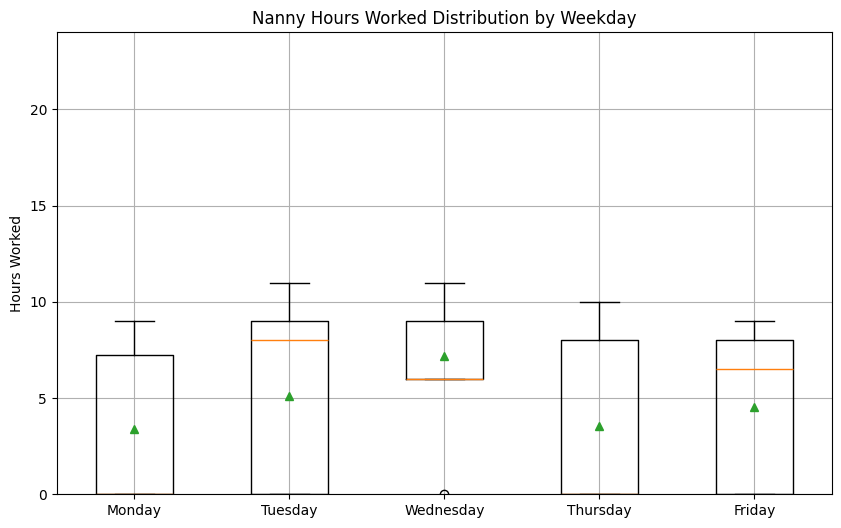

In [17]:
visualize_nanny_hours_per_weekday(optimal_nanny_characteristics[0])

In [18]:
top_score = max(optimal_fitness)

# find all of the characteristics that have the top score

top_characteristics = [optimal_nanny_characteristics[i] for i, score in enumerate(optimal_fitness) if score == top_score]

# find unique top characteristics

unique_top_characteristics = list({str(characteristics): characteristics for characteristics in top_characteristics}.values())

# find top 3 cheapest nannies that have the top score

cheapest_nannies = sorted(unique_top_characteristics, key=lambda x: x['hours_per_day'] * x['days_per_week'])

top_3_cheapest_nannies = cheapest_nannies[:3]

top_3_cheapest_nannies

[{'flexible': np.True_,
  'days_per_week': np.int64(4),
  'hours_per_day': np.int64(11),
  'actual_hours_worked': [[9, 8, 10, 0, 0],
   [0, 9, 6, 0, 0],
   [0, 0, 9, 8, 0],
   [8, 0, 6, 8, 7],
   [8, 10, 6, 0, 0],
   [0, 0, 9, 0, 9],
   [7, 0, 6, 0, 7],
   [0, 6, 6, 6, 0],
   [0, 0, 9, 6, 6],
   [0, 8, 6, 0, 0],
   [0, 8, 6, 0, 0],
   [0, 9, 9, 9, 0],
   [0, 0, 10, 8, 8],
   [9, 0, 10, 0, 0],
   [7, 0, 10, 0, 8],
   [6, 9, 6, 0, 0],
   [0, 0, 6, 0, 8],
   [0, 9, 9, 6, 0],
   [0, 9, 6, 0, 0],
   [6, 9, 10, 0, 0],
   [0, 9, 6, 9, 6],
   [0, 10, 10, 6, 8],
   [0, 0, 6, 0, 0],
   [8, 8, 6, 10, 0],
   [7, 8, 6, 9, 0],
   [9, 9, 7, 0, 7],
   [0, 9, np.int64(11), 9, 9],
   [9, 9, 0, 6, 9],
   [7, 10, 6, 0, 7],
   [0, 8, 9, 0, 8],
   [9, np.int64(11), 6, 0, 8],
   [0, 9, 6, 9, 0],
   [7, 0, 6, 8, 0],
   [0, 0, 6, 8, 7],
   [0, 9, 10, 9, 7],
   [8, 0, 6, 0, 8],
   [0, 9, 6, 0, 6],
   [7, 0, 7, 0, 0],
   [9, 0, 6, 9, 8],
   [8, 0, 9, 0, 7],
   [0, 9, 10, 0, 9],
   [8, 0, 10, 9, 8],
   [8, 0, 7, 

In [19]:
top_score = max(optimal_fitness)

# find all of the characteristics that have the top score

top_characteristics = [optimal_nanny_characteristics[i] for i, score in enumerate(optimal_fitness) if score == top_score]

# find unique top characteristics

unique_viable_characteristics = list({str(characteristics): characteristics for characteristics in viable_nanny_characteristics}.values())

# keep only 4 days per week nannies

unique_viable_characteristics = [characteristics for characteristics in unique_viable_characteristics if characteristics['days_per_week'] == 4]

# find top 3 cheapest nannies that have the top score

cheapest_viable_nannies = sorted(unique_viable_characteristics, key=lambda x: x['hours_per_day'] * x['days_per_week'])



In [20]:
for nanny in cheapest_viable_nannies:
    print(nanny['flexible'], nanny['days_per_week'], nanny['hours_per_day'])

True 4 8
True 4 9
True 4 10
True 4 11
True 4 12



Nanny with characteristics: True, 4 days per week, 8 hours per day
Max hours worked in a week: 32
Min hours worked in a week: 6
Average hours worked in a week: 22.346153846153847


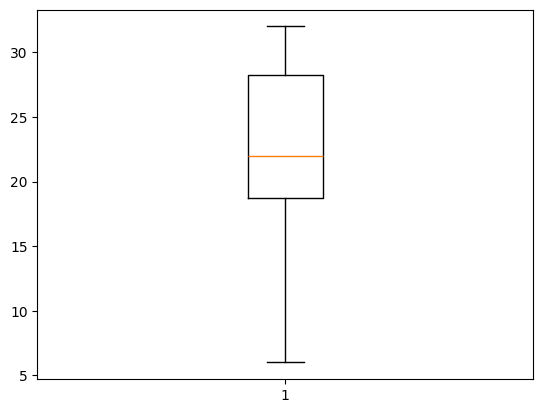


Nanny with characteristics: True, 4 days per week, 9 hours per day
Max hours worked in a week: 36
Min hours worked in a week: 6
Average hours worked in a week: 23.442307692307693


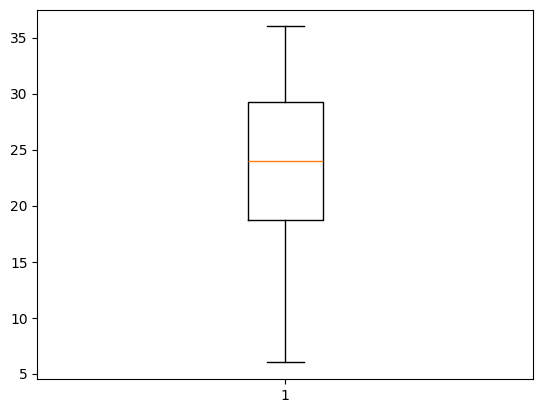


Nanny with characteristics: True, 4 days per week, 10 hours per day
Max hours worked in a week: 37
Min hours worked in a week: 6
Average hours worked in a week: 23.73076923076923


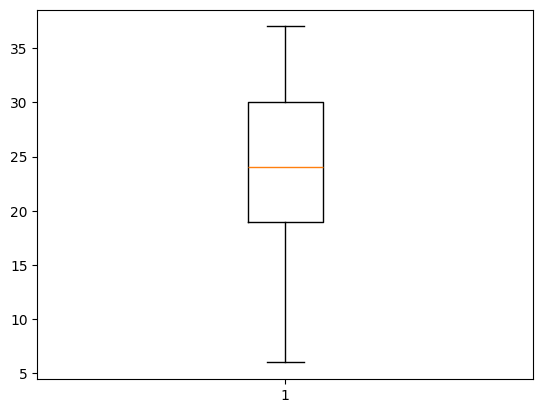


Nanny with characteristics: True, 4 days per week, 11 hours per day
Max hours worked in a week: 38
Min hours worked in a week: 6
Average hours worked in a week: 23.76923076923077


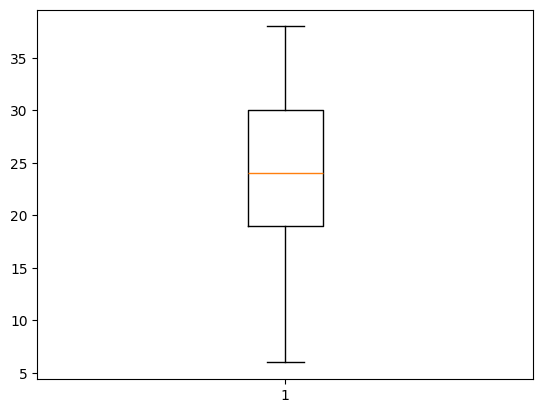


Nanny with characteristics: True, 4 days per week, 12 hours per day
Max hours worked in a week: 38
Min hours worked in a week: 6
Average hours worked in a week: 23.76923076923077


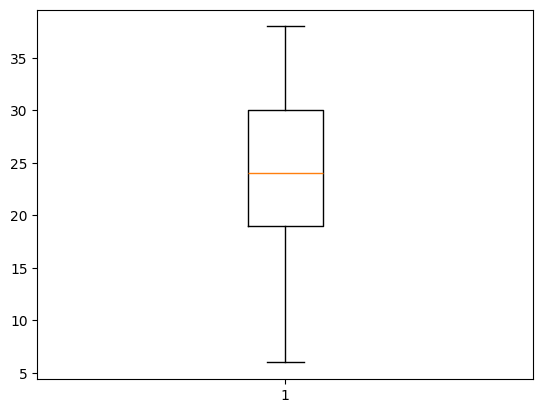

In [21]:
for nanny in cheapest_viable_nannies:
    week = 1
    max_hours = 0
    min_hours = 10000
    hours_list = []
    for schedule in nanny['actual_hours_worked']:
        hours_worked = sum(schedule)
        max_hours = max(max_hours, hours_worked)
        min_hours = min(min_hours, hours_worked)
        hours_list.append(hours_worked)
        if hours_worked >= 40:
            print(f"\nWeek {week}")
            print(f"\nHours worked: {hours_worked}")
            print(f"Schedule: {schedule}")
        week += 1
    print(f"\nNanny with characteristics: {nanny['flexible']}, {nanny['days_per_week']} days per week, {nanny['hours_per_day']} hours per day")
    print(f"Max hours worked in a week: {max_hours}")
    print(f"Min hours worked in a week: {min_hours}")
    print(f"Average hours worked in a week: {sum(hours_list) / len(hours_list)}")
    # print boxplot of hours worked
    plt.boxplot(hours_list)
    plt.show()

C:\Users\jperi\AppData\Local\Temp\ipykernel_14396\2107196169.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_plot, labels=days_of_week, showmeans=True)


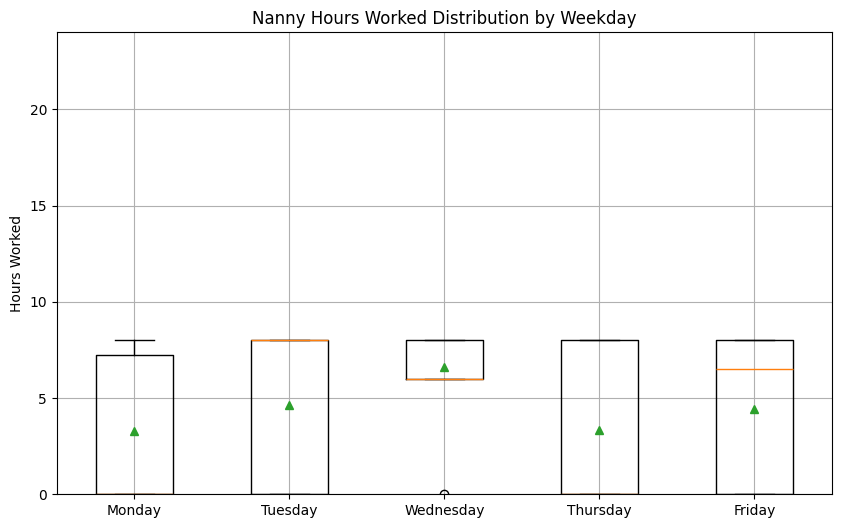

In [22]:
visualize_nanny_hours_per_weekday(cheapest_viable_nannies[0])

In [23]:
import matplotlib.pyplot as plt

# Function to apply the optimal nanny to a random year of parent schedules
def test_optimal_nanny(optimal_nanny, num_weeks=52):
    # Generate a new random year of parent schedules
    parent_2_schedules_test = [simulate_parent_2_schedule() for _ in range(num_weeks)]
    parent_1_schedules_test = [parent_1_schedules for _ in range(num_weeks)]
    
    missed_hours = 0
    covered_hours = 0
    wasted_hours = 0
    hour_coverage = np.zeros((7, 24))  # Track hourly coverage over the week
    
    # Iterate over each week to calculate the metrics
    for week in range(num_weeks):
        childcare_week = calculate_childcare_hours_wk(parent_1_schedules_test[week], parent_2_schedules_test[week])
        covered_hours_week = [0] * 24
        
        if optimal_nanny['flexible']:
            nanny_schedule = []
            for day in range(len(childcare_week)):
                needed_hours = [i for i, hour in enumerate(childcare_week[day]) if hour == 1]
                if needed_hours:
                    start_hour = needed_hours[0]  # Start when first needed
                    end_hour = start_hour + optimal_nanny['hours_per_day']
                    nanny_schedule.append((start_hour, min(end_hour, 24)))
                else:
                    nanny_schedule.append((-1, -1))  # No need for this day
        else:
            nanny_schedule = calculate_nanny_schedule(optimal_nanny, num_days=optimal_nanny['days_per_week'])

        # Calculate covered and wasted hours
        for day, (start_hour, end_hour) in enumerate(nanny_schedule):
            if start_hour == -1 or end_hour == -1:
                continue  # Skip non-working days
            for hour in range(int(start_hour), int(end_hour)):
                covered_hours_week[hour] += 1
                hour_coverage[day, hour] += 1  # Track coverage
                if childcare_week[day][hour] == 1:
                    covered_hours += 1  # Childcare is needed and covered
                else:
                    wasted_hours += 1  # Nanny is working but no childcare is needed
        
        # Calculate missed hours (childcare needed but not covered)
        for day in range(len(childcare_week)):  # Using the length of childcare_week dynamically
            for hour in range(24):
                if childcare_week[day][hour] == 1 and covered_hours_week[hour] == 0:
                    missed_hours += 1
    
    return missed_hours, covered_hours, wasted_hours, hour_coverage


In [24]:
# Function to simulate 1,000 years of schedules
def simulate_1000_years(opt_nanny):
    total_missed_hours = 0
    total_covered_hours = 0
    total_wasted_hours = 0
    total_hour_coverage = np.zeros((7, 24))  # Aggregate over 1,000 years
    
    for _ in range(1000):
        missed_hours_year, covered_hours_year, wasted_hours_year, hour_coverage_year = test_optimal_nanny(opt_nanny)
        total_missed_hours += missed_hours_year
        total_covered_hours += covered_hours_year
        total_wasted_hours += wasted_hours_year
        total_hour_coverage += hour_coverage_year
    
    return total_missed_hours, total_covered_hours, total_wasted_hours, total_hour_coverage

In [25]:
# Visualization function for the performance metrics
def visualize_nanny_performance(missed_hours, covered_hours, wasted_hours):
    labels = ['Missed Hours', 'Covered Hours', 'Wasted Hours']
    values = [missed_hours, covered_hours, wasted_hours]

    perc_values = [100 * value / sum(values) for value in values]
    
    plt.bar(labels, perc_values, color=['red', 'green', 'orange'])
    plt.title('Nanny Performance over 1,000 Years')
    plt.ylabel('Percentage of Hours')

    # Add labels on top of each bar
    for i, value in enumerate(perc_values):
        plt.text(i, value + 0.5, f"{value:.2f}%", ha='center')
    plt.show()

In [26]:
# Visualization function for the nanny's schedule heatmap
def visualize_nanny_schedule_heatmap(hour_coverage):
    plt.figure(figsize=(10, 6))
    plt.imshow(hour_coverage, aspect='auto', cmap='Blues', origin='lower')
    plt.colorbar(label='Number of Covered Hours')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Day of the Week')
    plt.title('Nanny Coverage Heatmap over 1,000 Years')
    plt.yticks(ticks=np.arange(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.xticks(ticks=np.arange(24), labels=[f'{h}:00' for h in range(24)], rotation=45)
    plt.show()

In [27]:
optimal_nanny_char = cheapest_viable_nannies[0]
second_nanny_char = cheapest_viable_nannies[1]
third_nanny_char = cheapest_viable_nannies[2]
fourth_nanny_char = cheapest_viable_nannies[3]
fifth_nanny_char = cheapest_viable_nannies[4]



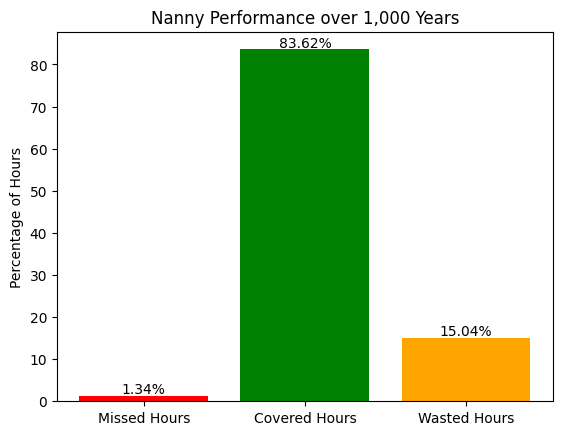

In [28]:
# Simulate 1,000 years
missed_hours, covered_hours, wasted_hours, hour_coverage = simulate_1000_years(optimal_nanny_char)

# Visualize the performance metrics
visualize_nanny_performance(missed_hours, covered_hours, wasted_hours)



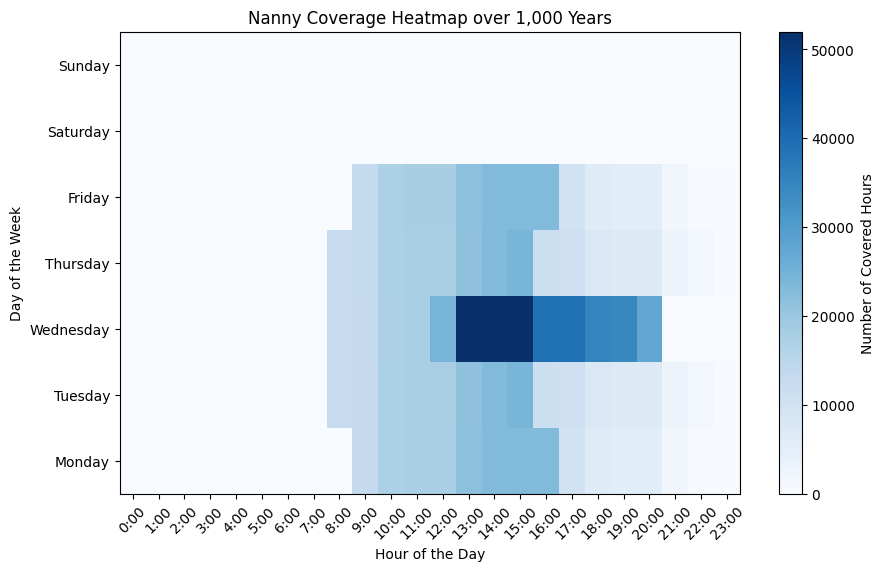

In [29]:
# Visualize the nanny's schedule heatmap
visualize_nanny_schedule_heatmap(hour_coverage)

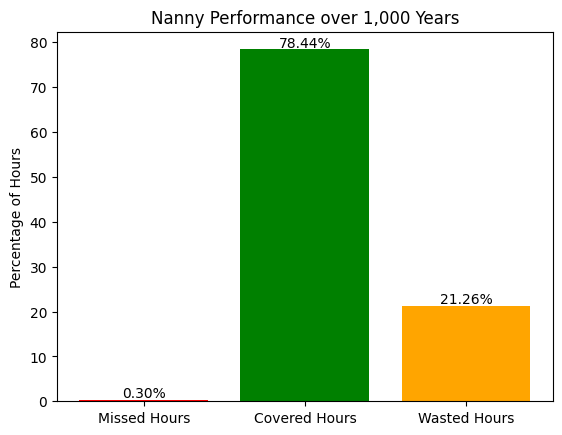

In [30]:
# Simulate 1,000 years
missed_hours, covered_hours, wasted_hours, hour_coverage = simulate_1000_years(second_nanny_char)

# Visualize the performance metrics
visualize_nanny_performance(missed_hours, covered_hours, wasted_hours)


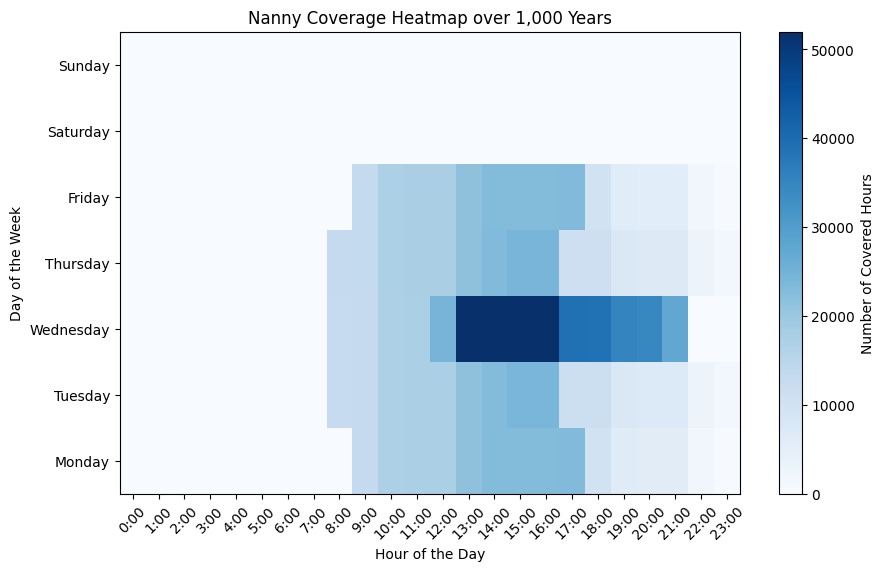

In [31]:
# Visualize the nanny's schedule heatmap
visualize_nanny_schedule_heatmap(hour_coverage)

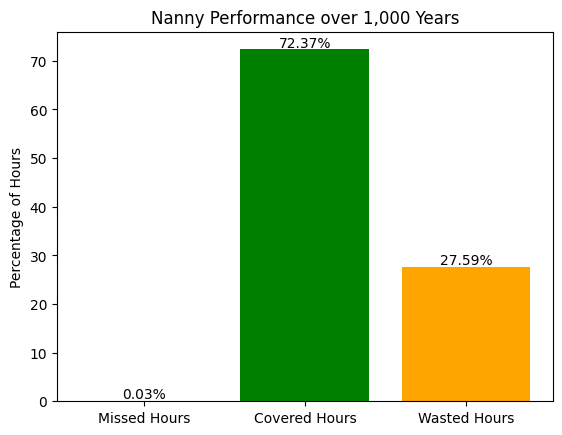

In [32]:
# Simulate 1,000 years
missed_hours, covered_hours, wasted_hours, hour_coverage = simulate_1000_years(third_nanny_char)

# Visualize the performance metrics
visualize_nanny_performance(missed_hours, covered_hours, wasted_hours)



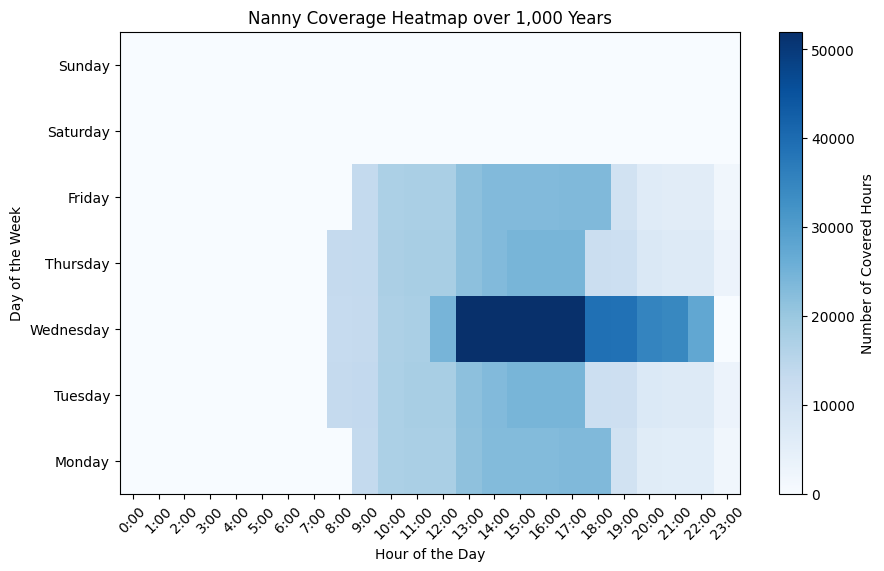

In [33]:
# Visualize the nanny's schedule heatmap
visualize_nanny_schedule_heatmap(hour_coverage)

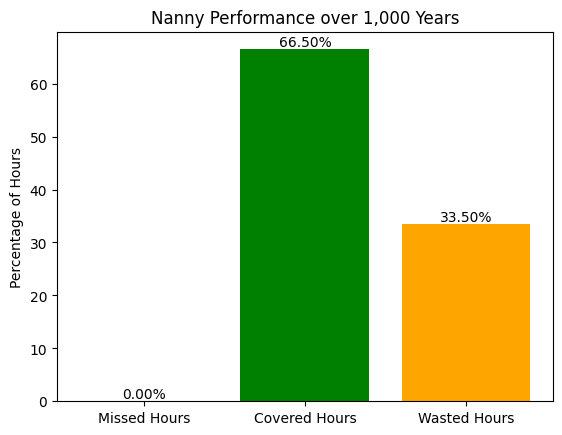

In [34]:
# Simulate 1,000 years
missed_hours, covered_hours, wasted_hours, hour_coverage = simulate_1000_years(fourth_nanny_char)

# Visualize the performance metrics
visualize_nanny_performance(missed_hours, covered_hours, wasted_hours)

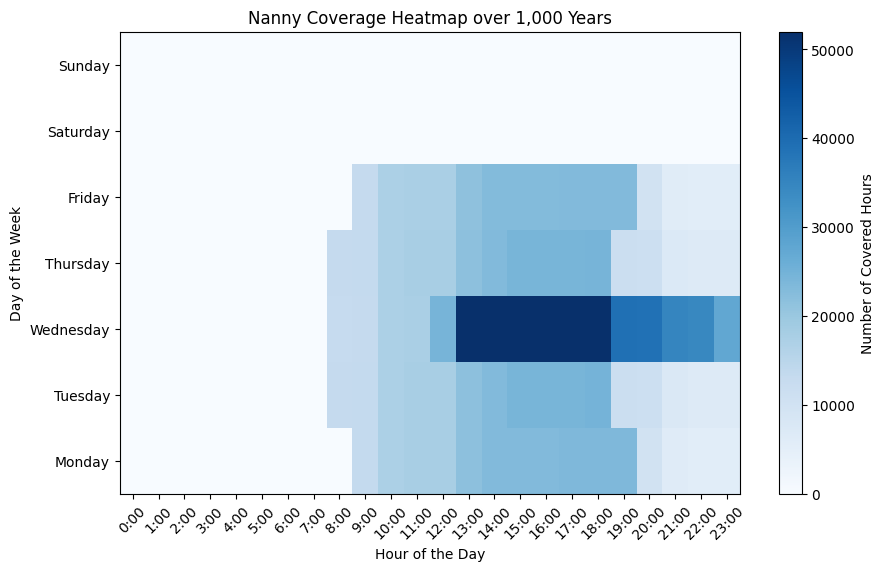

In [35]:
# Visualize the nanny's schedule heatmap
visualize_nanny_schedule_heatmap(hour_coverage)

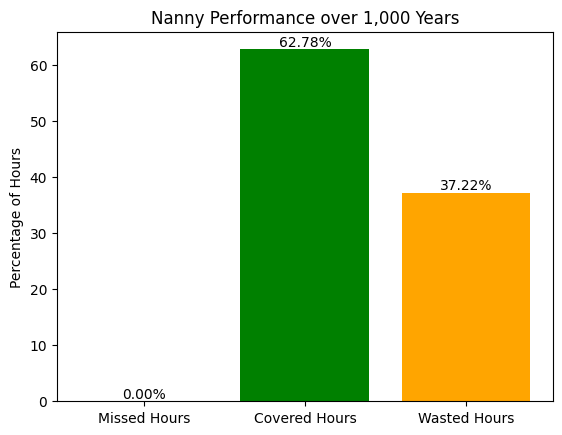

In [36]:
# Simulate 1,000 years
missed_hours, covered_hours, wasted_hours, hour_coverage = simulate_1000_years(fifth_nanny_char)

# Visualize the performance metrics
visualize_nanny_performance(missed_hours, covered_hours, wasted_hours)

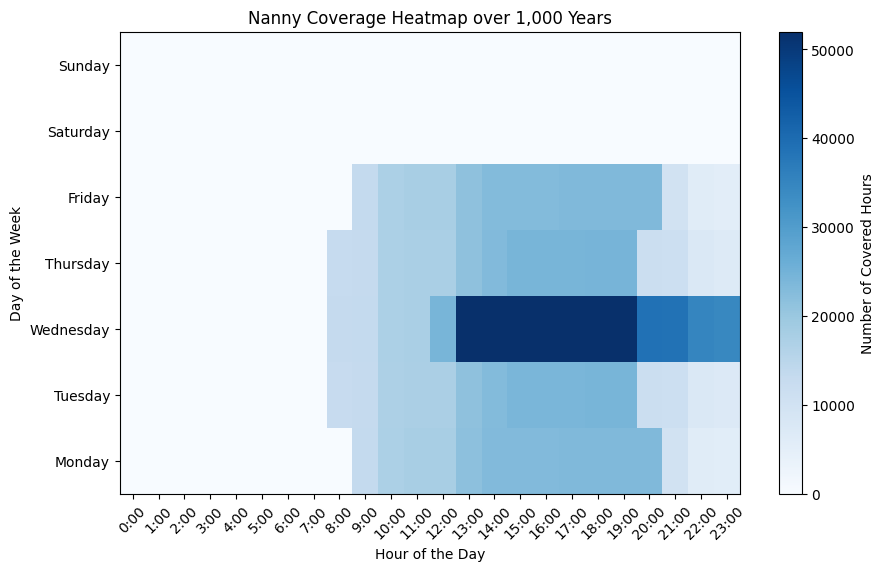

In [37]:
# Visualize the nanny's schedule heatmap
visualize_nanny_schedule_heatmap(hour_coverage)

In [38]:
print(hour_coverage)

[[    0.     0.     0.     0.     0.     0.     0.     0.     0. 13228.
  17207. 17682. 17682. 21574. 23054. 23054. 23054. 23296. 23296. 23296.
  23296. 10068.  6089.  5614.]
 [    0.     0.     0.     0.     0.     0.     0.     0. 12773. 13037.
  16918. 17375. 17375. 21339. 22831. 24074. 24074. 24074. 24308. 24308.
  11535. 11271.  7390.  6933.]
 [    0.     0.     0.     0.     0.     0.     0.     0. 13018. 13278.
  17180. 17642. 24348. 52000. 52000. 52000. 52000. 52000. 52000. 52000.
  38982. 38722. 34820. 34358.]
 [    0.     0.     0.     0.     0.     0.     0.     0. 12954. 13176.
  17101. 17621. 17621. 21500. 22990. 24196. 24196. 24196. 24447. 24447.
  11493. 11271.  7346.  6826.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0. 13226.
  17213. 17674. 17674. 21486. 22893. 22893. 22893. 23157. 23157. 23157.
  23157.  9931.  5944.  5483.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.   

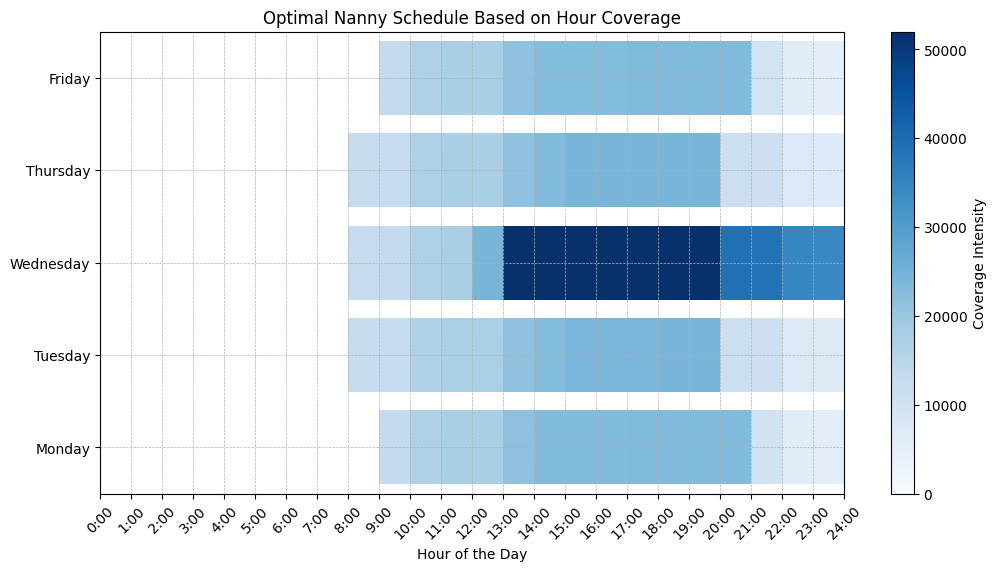

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def visualize_optimal_nanny_schedule(hour_coverage):
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Normalize hour_coverage to range between 0 and 1 for color intensity
    max_coverage = np.max(hour_coverage)
    normalized_coverage = hour_coverage / max_coverage
    
    # Plot the nanny's work schedule for each day
    for day_index in range(5):  # Assuming 5 workdays (Monday to Friday)
        for hour in range(24):
            coverage_intensity = normalized_coverage[day_index, hour]
            if coverage_intensity > 0:
                ax.barh(day_index, 1, left=hour, color=plt.cm.Blues(coverage_intensity))
    
    # Customize the plot
    ax.set_yticks(range(len(days_of_week)))
    ax.set_yticklabels(days_of_week)
    ax.set_xticks(range(0, 25, 1))
    ax.set_xticklabels([f'{h}:00' for h in range(25)], rotation=45)
    ax.set_xlim(0, 24)
    ax.set_ylim(-0.5, 4.5)
    ax.set_xlabel('Hour of the Day')
    ax.set_title('Optimal Nanny Schedule Based on Hour Coverage')

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0, max_coverage))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Coverage Intensity')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


# Example usage
visualize_optimal_nanny_schedule(hour_coverage)